In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import time
import random
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam

torch.backends.cudnn.deterministic = True
device = torch.device("cuda")

print("CUDA visible devices: " + str(torch.cuda.device_count()))

D:\Tool\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


CUDA visible devices: 1


In [2]:
# Check https://github.com/mv-lab/AISP/utils.py for more utils for RAW image manipulation.

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    

def load_raw(raw, max_val=2**10):
    raw = np.load (raw)/ max_val
    return raw.astype(np.float32)


########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [3]:
def get_filenames(PATH):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.png'))
    valid_rgbs = sorted(glob(PATH + '/val/*'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

In [4]:
PATH    = f'data'

BATCH_TRAIN = 1
BATCH_TEST  = 1

# if DEBUG use only 250 datasamples, if not all the dataset
DEBUG = False 

train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)

Training samples: 2952 	 Validation samples: 120


## Dataloader

In [5]:
class LoadData(Dataset):

    def __init__(self, root, rgb_files, raw_files=None, debug=False, test=None):
        
        self.root = root
        self.test = test
        self.rgbs = sorted(rgb_files)
        if self.test:
            self.raws = None
        else:
            self.raws = sorted(raw_files)
            
        self.debug = debug
        if self.debug:
            self.rgbs = self.rgbs[:100]
            self.raws = self.raws[:100]
        
    def __len__(self):
        return len(self.rgbs)

    def __getitem__(self, idx):

        rgb = load_img (self.rgbs[idx], norm=True)
        rgb = torch.from_numpy(rgb.transpose((2, 0, 1)))
        
        if self.test:
            return rgb, self.rgbs[idx]
        else:
            raw = load_raw (self.raws[idx])
            raw = torch.from_numpy(raw.transpose((2, 0, 1)))
            return rgb, raw

In [6]:
train_dataset = LoadData(root=PATH, rgb_files=train_rgbs,raw_files=train_raws, debug=DEBUG, test=False)
train_loader  = DataLoader(dataset=train_dataset, batch_size=BATCH_TRAIN, shuffle=True, num_workers=0,
                          pin_memory=True, drop_last=True)

test_dataset = LoadData(root=PATH, rgb_files=valid_rgbs, test=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_TEST, shuffle=False, num_workers=0,
                         pin_memory=True, drop_last=False)

print (f'Train Dataloader BS={BATCH_TRAIN} N={len(train_loader)} / Test/Val Dataloader BS={BATCH_TEST} N={len(test_loader)}')

Train Dataloader BS=1 N=2952 / Test/Val Dataloader BS=1 N=120


## model

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.models as models

class ReRAW(nn.Module):
    def __init__(
        self,
        in_size=3,
        out_size=4,
        target_size=(512, 512),
        hidden_size=128,
        n_layers=8,
        gammas=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
    ):

        super().__init__()

        self.gammas = gammas

        self.hidden_size = hidden_size
        self.target_size = target_size

        self.color_reconstruction = ColorReconstructionModule(
            in_size=in_size,
            hidden_size=hidden_size,
            out_size=hidden_size,
            n_layers=n_layers,
        )

        self.global_context_encoder = GlobalContextModule(hidden_size)
        self.gamma_scaling_encoder = GlobalContextModule(len(self.gammas))
        self.softmax = nn.Softmax(dim=1)

        self.heads = nn.ModuleList()
        for _ in range(len(self.gammas)):
            self.heads.append(
                Head(
                    in_size=hidden_size,
                    hidden_size=hidden_size,
                    out_size=out_size,
                    n_layers=n_layers,
                )
            )

    def forward(self, x, global_img):
        b, c, h, w = global_img.size()

        global_features = self.global_context_encoder(global_img)
        global_features = global_features.view(b, self.hidden_size, 1, 1)
        global_features = global_features.repeat(1, 1, self.target_size[0], self.target_size[1])

        x = self.color_reconstruction(x)
        x = x * global_features

        scaling = self.gamma_scaling_encoder(global_img)
        scaling = self.softmax(scaling)

        y = 0
        outputs = []

        for head_no, head in enumerate(self.heads):
            scale = scaling[:, head_no : head_no + 1].view(b, 1, 1, 1).repeat(1, 4, 1, 1)
            y0 = torch.clip(head(x), 0, None)
            y += torch.pow(y0, 1 / self.gammas[head_no]) * scale
            outputs.append(y0)
        
        outputs = torch.cat(outputs, dim=1)

        return y, outputs, scaling


class ColorReconstructionModule(nn.Module):
    def __init__(
        self,
        in_size=3,
        initial_size=32,
        hidden_size=128,
        out_size=128,
        n_layers=4,
        bias=True,
        act=nn.LeakyReLU,
        val=0.1,
    ):

        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(
                    in_size,
                    initial_size * in_size,
                    kernel_size=3,
                    stride=1,
                    padding=0,
                    bias=bias,
                    padding_mode="reflect",
                    groups=3,
                ),
                act(val),
            )
        )
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(initial_size * in_size, hidden_size, kernel_size=2, stride=2, bias=bias),
                act(val),
            )
        )
        for i in range(n_layers-1):
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(hidden_size, hidden_size, kernel_size=1, stride=1, bias=bias),
                    act(val),
                )
            )
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(hidden_size, out_size, kernel_size=1, stride=1, bias=bias), act(val)
            )
        )

        for seq in self.layers:
            for layer in seq.children():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layers[0](x)
        x = self.layers[1](x)
        for layer in self.layers[2:-1]:
            x = x + layer(x)
        x = self.layers[-1](x)

        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)  # 调整大小
        return x


class GlobalContextModule(nn.Module):
    def __init__(self, out_size=128):
        super().__init__()
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(512, out_size)
        # self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = self.act(x)
        return x


class Head(nn.Module):
    def __init__(
        self,
        in_size=128,
        hidden_size=128,
        out_size=4,
        n_layers=4,
        bias=True,
        act=nn.LeakyReLU,
        val=0.1,
    ):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(
            nn.Sequential(
                nn.Conv2d(in_size, hidden_size, kernel_size=1, stride=1, padding=0, bias=bias),
                act(val),
            )
        )
        for i in range(n_layers - 2):
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(
                        hidden_size, hidden_size, kernel_size=1, stride=1, padding=0, bias=bias
                    ),
                    act(val),
                )
            )

        self.layers.append(
            nn.Sequential(
                nn.Conv2d(hidden_size, out_size, kernel_size=1, stride=1, padding=0, bias=bias),
                act(val),
            )
        )

        for seq in self.layers:
            for layer in seq.children():
                if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                    init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        init.zeros_(layer.bias)

    def forward(self, x):
        x = self.layers[0](x)
        for layer in self.layers[1:-1]:
            x = x + layer(x)
        x = self.layers[-1](x)
        return x


class l1_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = torch.abs(x - y).mean()
        return loss


class hard_log_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = (-1 * torch.log(1 - torch.clamp(torch.abs(x - y),0,1) + 1e-6)).mean()
        return loss

## Training

In [26]:
class CFG:
    
    encoder = (3,64,128,256)
    decoder = (256, 128, 64)
    out_ch  = 4
    out_sz  = (512, 512)
    lr      = 1e-4
    lr_decay= 1e-6
    epochs  = 100
    loss    = nn.MSELoss()
    name    = 'unet-rev-isp.pt'
    out_dir = './out6'
    save_freq = 1

In [27]:
model = ReRAW()
# 加载权重文件
# pretrained_weights_path = r"E:\rgb2raw\out2\128.pt"
# model = torch.load(pretrained_weights_path, map_location=device, weights_only=False)
model = model.to(device)

opt   = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.lr_decay)

criterion = CFG.loss
metrics   = defaultdict(list)

In [28]:
len(metrics['train_loss'])

0

In [29]:
min_loss = 1
min_loss_epoch = -1
for epoch in range(CFG.epochs):
    
    torch.cuda.empty_cache()
    start_time = time.time()
    train_loss = []

    model.train()
    
    for rgb_batch, raw_batch in tqdm(train_loader):
        opt.zero_grad()

        rgb_batch = rgb_batch.to(device)
        raw_batch = raw_batch.to(device)
        
        recon_raw = model(rgb_batch, rgb_batch)

        loss = criterion(raw_batch, recon_raw)
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    now_loss = np.mean(train_loss)
    metrics['train_loss'].append(now_loss)
    if now_loss < min_loss:
        min_loss = now_loss
        min_loss_epoch = len(metrics['train_loss'])

    display.clear_output()
    plt.figure(figsize=(20, 7))
    ax1 = plt.subplot(2, 2, 1)
    reconst_raw = postprocess_raw(demosaic(recon_raw[-1].detach().cpu().permute(1, 2, 0).numpy()))
    gt_raw = postprocess_raw(demosaic(raw_batch[-1].detach().cpu().permute(1, 2, 0).numpy()))
    cmp_raw_gt = np.concatenate([gt_raw, reconst_raw], axis=1)
    ax1.imshow(cmp_raw_gt)
    ax1.set_title('(left) GT / (right) Reconst. RAW')

    ax2 = plt.subplot(2, 2, 3)
    ax2.imshow(rgb_batch[-1].detach().cpu().permute(1, 2, 0).numpy())
    ax2.set_title('RGB')

    ax3 = plt.subplot(1, 2, 2)
    #---------------------------------------------metrics['train_loss'] 里有 loss 数据---------------------------------------------
    ax3.plot(metrics['train_loss'], label='train')
    ax3.set_xlabel('Epochs', fontsize=18)
    ax3.set_ylabel('Loss', fontsize=18)
    ax3.grid()

    plt.show()

    print(f"Epoch {epoch + 1} of {CFG.epochs} took {time.time() - start_time:.3f}s\n")

    if ((epoch + 1) % CFG.save_freq == 0):
        torch.save(model, os.path.join(CFG.out_dir , f"{len(metrics['train_loss'])}.pt"))


torch.save(model.state_dict(), os.path.join(CFG.out_dir ,CFG.name))
print("最小的 loss 权重为：",min_loss_epoch, ".pt")

  0%|                                                                                         | 0/2952 [00:00<?, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x00000224C1C68500>
Traceback (most recent call last):
  File "D:\Tool\anaconda3\Lib\site-packages\tqdm\std.py", line 1196, in __iter__
  File "D:\Tool\anaconda3\Lib\site-packages\tqdm\std.py", line 1265, in close
    def close(self):

KeyboardInterrupt: 
  0%|                                                                                         | 0/2952 [00:51<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 26.18 GiB is allocated by PyTorch, and 70.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
# 查看 loss
min_loss = 1
min_loss_epoch = -1
for i,v in enumerate(metrics['train_loss']):
    print(f"第{i+1}代:  ",v)
    if v < min_loss:
            min_loss = v
            min_loss_epoch = i

print(f"最小值为：{min_loss} ，它属于第 {min_loss_epoch+1} 代")

第1代:   0.19369170495067078
第2代:   0.19441896785204815
第3代:   0.19357930717755603
第4代:   0.19307769789228943
第5代:   0.19346164141795597
第6代:   0.1945465790791298
第7代:   0.19354277005699044
第8代:   0.19339160635914887
第9代:   0.1930692800662031
第10代:   0.19322467190607642
第11代:   0.1930772928127763
第12代:   0.19317488167514232
第13代:   0.19298706373325536
第14代:   0.19361273126231687
第15代:   0.19358453345865484
第16代:   0.1926467488757096
第17代:   0.1925152210890979
第18代:   0.19366753020996594
第19代:   0.19261414129312565
第20代:   0.19443919543957983
第21代:   0.1920175255189072
第22代:   0.1922569594886959
第23代:   0.19253892183361418
第24代:   0.19229484508118674
第25代:   0.19339115201983026
第26代:   0.19234597219085928
第27代:   0.19233878641649807
第28代:   0.19201944319667763
第29代:   0.19451755444170277
第30代:   0.19227150641209653
第31代:   0.1918090578492134
第32代:   0.1920829328613421
第33代:   0.19236991997080935
第34代:   0.1928487638028396
第35代:   0.19268455312106464
第36代:   0.19213373170983425
第37代:   0.1

## Submission

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

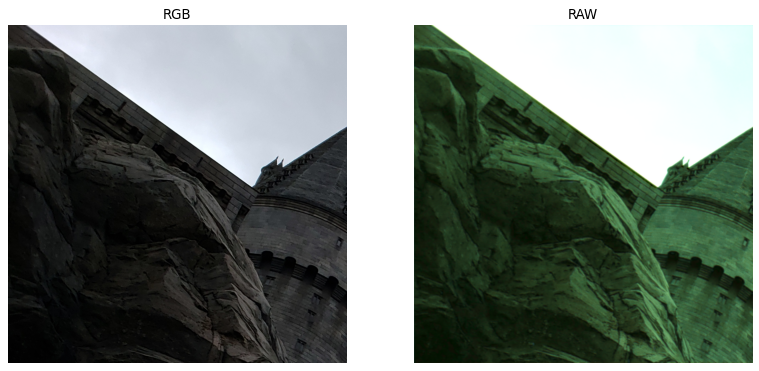

 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [00:13<00:02,  7.01it/s]

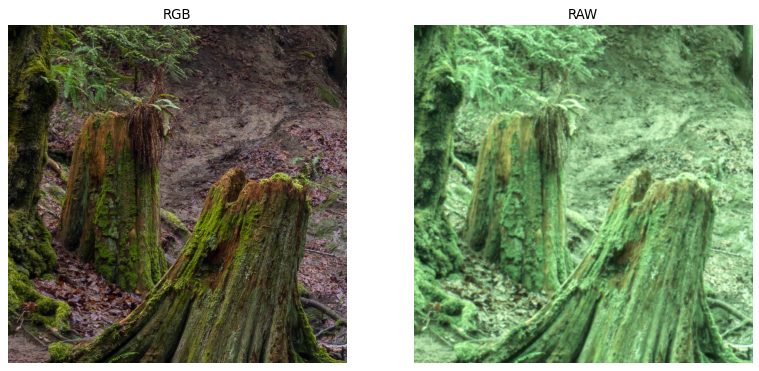

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:16<00:00,  7.32it/s]

0.0021852533022562663


In [14]:
SUBMISSION_PATH = './submission/'
runtime = []

cnt = 0
model.eval()
with torch.no_grad():
    for (rgb_batch, rgb_name) in tqdm(test_loader):
        rgb_batch = rgb_batch.to(device)
        rgb_name  = rgb_name[0].split('/')[-1].replace('.png', '')
        
        st = time.time()
        recon_raw = model(rgb_batch)
        tt = time.time() - st
        runtime.append(tt)
        
        recon_raw = recon_raw[0].detach().cpu().permute(1, 2, 0).numpy()
        rgb_batch = rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy()
        
        if cnt % 100 == 0:
            plot_pair(rgb_batch, postprocess_raw(demosaic(recon_raw)))
        
        ## save as np.uint16
        assert recon_raw.shape[-1] == 4
        recon_raw = (recon_raw * 1024).astype(np.uint16)
        np.save(SUBMISSION_PATH + rgb_name + '.npy', recon_raw) 
        cnt+=1

print (np.mean(runtime)) ## add into the readme!